# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [81]:
#%pip install tensorflow --upgrade
#%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

%matplotlib inline

Load the `mnist` dataset and normalize in the range [0, 1]

In [82]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [71]:
n_orientations = 16
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [72]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

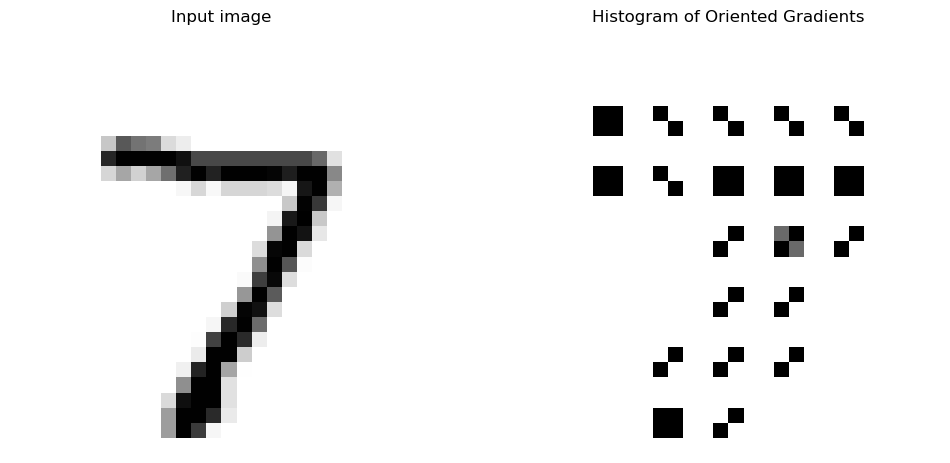

In [73]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets


In [74]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


In [75]:
hog_size

784

Create the MLP

In [83]:
model = Sequential()
model.add(Dense(128, input_shape=(hog_size,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               100480    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Define some constants and train the MLP

In [84]:
batch_size = 256
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/10
211/211 [==============================] - 3s 10ms/step - loss: 0.4450 - accuracy: 0.8870 - val_loss: 0.1014 - val_accuracy: 0.9732
Epoch 2/10
211/211 [==============================] - 2s 9ms/step - loss: 0.1510 - accuracy: 0.9541 - val_loss: 0.0770 - val_accuracy: 0.9775
Epoch 3/10
211/211 [==============================] - 2s 8ms/step - loss: 0.1184 - accuracy: 0.9646 - val_loss: 0.0689 - val_accuracy: 0.9790
Epoch 4/10
211/211 [==============================] - 2s 9ms/step - loss: 0.1007 - accuracy: 0.9689 - val_loss: 0.0649 - val_accuracy: 0.9797
Epoch 5/10
211/211 [==============================] - 2s 8ms/step - loss: 0.0895 - accuracy: 0.9722 - val_loss: 0.0637 - val_accuracy: 0.9797
Epoch 6/10
211/211 [==============================] - 2s 9ms/step - loss: 0.0819 - accuracy: 0.9745 - val_loss: 0.0618 - val_accuracy: 0.9798
Epoch 7/10
211/211 [==============================] - 2s 7ms/step - loss: 0.0737 - accuracy: 0.9770 - val_loss: 0.0617 - val_accuracy: 0.9807
Epoch

Show the performance of the model

Test score: 0.061707451939582825
Test accuracy: 0.9807999730110168


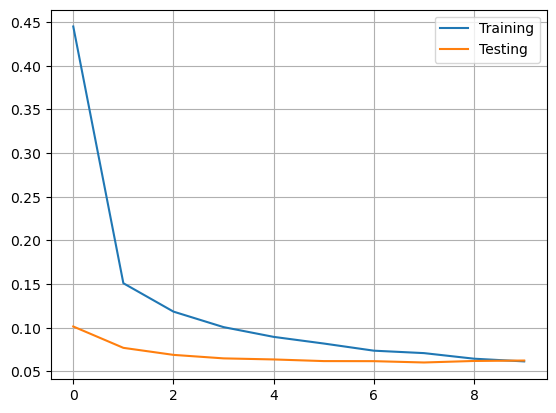

In [85]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [79]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

313/313 [==============================] - 1s 3ms/step


array([[ 970,    1,    2,    0,    0,    1,    4,    1,    0,    1],
       [   0, 1127,    2,    2,    0,    0,    2,    0,    2,    0],
       [   2,    4, 1016,    2,    1,    0,    0,    5,    2,    0],
       [   0,    1,    2,  989,    1,    7,    0,    2,    8,    0],
       [   0,    6,    3,    1,  960,    0,    3,    1,    2,    6],
       [   2,    1,    1,    5,    0,  878,    4,    0,    1,    0],
       [   5,    1,    0,    0,    2,    5,  944,    0,    1,    0],
       [   1,    2,    7,    3,    5,    0,    0,  998,    4,    8],
       [   4,    1,    2,    4,    2,    2,    2,    4,  951,    2],
       [   2,    4,    0,    5,    7,    5,    1,    6,    7,  972]],
      dtype=int64)

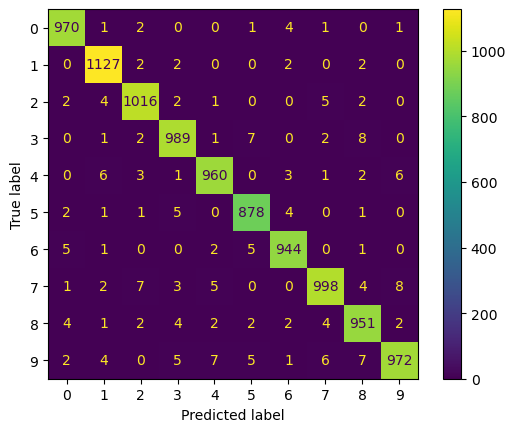

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred))
disp.plot()
pl.show()